In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Setup hyperparameters:
density = 533           # https://sci.esa.int/web/rosetta/-/14615-comet-67p
r_T = 5000              # Target altitude
t_end = 20*3600.0       # Final time
t_0 = 0                 # Starting time
dt = 800.0             # Number of steps along orbit 

# Bounds for initial domain: [r_x,r_y,r_z,v_x,v_y,v_z]
lb, ub = [-6000,-6000,-6000,0,0,0],[6000,6000,6000,2.5,2.5,2.5]

# Optimization
pop_size = 10
num_gen = 32

In [44]:
import math
import pygmo as pg
import matplotlib.pyplot as plt
import udp_basic

# Setup class
udp = udp_basic.udp_obj(density, r_T, t_end, t_0, dt, lb, ub)

# Define problem
prob = pg.problem(udp)
print(prob)

# Setup algorithm
algo = pg.algorithm(pg.sade(gen = num_gen))
pop = pg.population(prob = prob, size = pop_size)

Physical dimension along x (UN-normalized):  5002.5703125 Km
Problem name: <class 'udp_basic.udp_obj'>
	C++ class name: pybind11::object

	Global dimension:			6
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-6000, -6000, -6000, 0, 0, ... ]
	Upper bounds: [6000, 6000, 6000, 2.5, 2.5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [45]:
# Run optimization
algo.set_verbosity(1)
pop = algo.evolve(pop)



   Gen:        Fevals:          Best:             F:            CR:            dx:            df:
      1             10          50312       0.445289       0.800559        14167.8        65379.3
      2             20        39162.3       0.448532       0.910111        10535.8        75320.6
      3             30          31347       0.448532       0.910111        6320.77        83135.9
      4             40          31347       0.448532       0.910111        8997.56        69024.2
      5             50          31347       0.448532       0.910111        8997.56        69024.2
      6             60        31200.9       0.710011       0.746587        7631.87        65871.9
      7             70        31200.9       0.710011       0.746587        6947.95        49338.2
      8             80        8833.16       0.710011       0.746587         6947.4        71705.9
      9             90        8833.16       0.710011       0.746587        7269.12        48045.5
     10            

In [46]:
# Logs for output
print("Champion fitness value: ", pop.champion_f) 
print("Champion chromosome: ", pop.champion_x) 

# Retrieving champion chromosome
x = pop.champion_x

# Compute optimized trajectory
fit_val, r_store, v_store, a_store = udp.compute_trajectory(x)

# Plot optimized trajectory
udp.plot_trajectory(r_store)

Champion fitness value:  [421.1559934]
Champion chromosome:  [ 1.84147342e+03  5.27731301e+02 -4.59747440e+03  2.79962920e-01
  5.16364830e-01  9.12182385e-02]


BokehModel(combine_events=True, render_bundle={'docs_json': {'113df404-3825-44b6-8b03-240b29b7ad10': {'defs': …

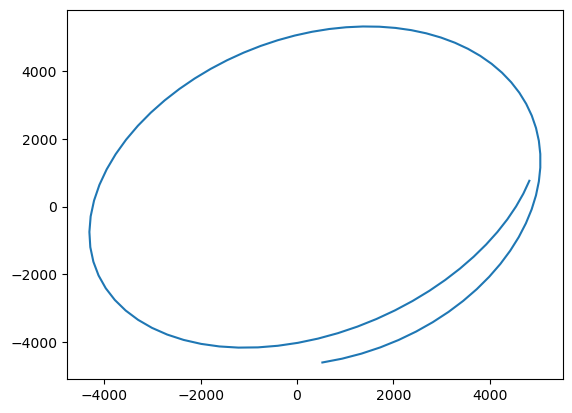

In [50]:
plt.plot(r_store[1],r_store[2])